# Basline GPU DenseNet Model

Trying out a densenet201 architecture for Xray Pneumonia Detection. This model shall serve as a baseline for a TPU accelerated model.

In [1]:
import numpy as np
import pandas as pd
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
import tensorflow as tf
from tensorflow import keras

## Early processing of metadata for easier model training:

In [2]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('../input/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('../input/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
104325,00027881_000.png,No Finding,0,27881,50,F,PA,2992,2991,0.143,0.143,NaN,../input/data/images_011/images/00027881_000.png
19487,00005176_012.png,No Finding,12,5176,68,M,PA,2500,2048,0.168,0.168,NaN,../input/data/images_003/images/00005176_012.png
92700,00023138_002.png,No Finding,2,23138,40,M,PA,2550,2680,0.143,0.143,NaN,../input/data/images_010/images/00023138_002.png


In [3]:
# Using only PA images
pa_xray_df = all_xray_df.drop(all_xray_df.loc[all_xray_df['View Position']=='AP'].index)

In [4]:
## Splitting finding lables into individual rows
cleaned = pa_xray_df.rename(columns={'Finding Labels': 'labels'})
cleaned = cleaned.set_index('Image Index').labels.str.split('|', expand=True).stack().reset_index(level=1, drop=True).to_frame('lables')
cleaned.head()

,lables
Image Index,
00000001_000.png,Cardiomegaly
00000001_001.png,Cardiomegaly
00000001_001.png,Emphysema
00000001_002.png,Cardiomegaly
00000001_002.png,Effusion


In [5]:
# getting dummy variables for the lables and grouping by the index.
cleaned = pd.get_dummies(cleaned, columns=['lables']).groupby(level=0).sum()

In [6]:
cleaned.head()

,lables_Atelectasis,lables_Cardiomegaly,lables_Consolidation,lables_Edema,lables_Effusion,lables_Emphysema,lables_Fibrosis,lables_Hernia,lables_Infiltration,lables_Mass,lables_No Finding,lables_Nodule,lables_Pleural_Thickening,lables_Pneumonia,lables_Pneumothorax
Image Index,,,,,,,,,,,,,,,
00000001_000.png,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
00000001_001.png,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
00000001_002.png,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
00000002_000.png,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
00000003_000.png,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [7]:
# ensuring both data frames use the same index
pa_xray_df.set_index('Image Index', inplace=True)

In [8]:
# merging dummy variable columns with the data frame containing the image paths.
prepared_df = pa_xray_df.merge(cleaned, left_index = True, right_index=True)

In [9]:
prepared_df.head()

,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],...,lables_Emphysema,lables_Fibrosis,lables_Hernia,lables_Infiltration,lables_Mass,lables_No Finding,lables_Nodule,lables_Pleural_Thickening,lables_Pneumonia,lables_Pneumothorax
Image Index,,,,,,,,,,,,,,,,,,,,,
00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,...,0,0,0,0,0,0,0,0,0,0
00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,...,1,0,0,0,0,0,0,0,0,0
00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,...,0,0,0,0,0,0,0,0,0,0
00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,...,0,0,0,0,0,1,0,0,0,0
00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,...,0,0,1,0,0,0,0,0,0,0


In [10]:
## Renamiong dummy column to 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification

prepared_df.rename(columns={'lables_Pneumonia': 'pneumonia_class'}, inplace=True)

In [11]:
# Checking that class is binary
prepared_df.pneumonia_class.unique()

array([0, 1], dtype=uint8)

In [12]:
prepared_df.to_csv("prepared_df.csv")

## Train-Validation Split:

In [13]:
prepared_df = pd.read_csv("prepared_df.csv", index_col="Image Index")

In [14]:
# checking class imbalance
prepared_df['pneumonia_class'].value_counts()

0    66680
1      630
Name: pneumonia_class, dtype: int64

In [15]:
train_data, val_data = train_test_split(prepared_df, test_size=0.2, stratify = prepared_df['pneumonia_class'], random_state=42)

# Data Preprocessing:

#### First suggestion: perform some image augmentation on your data

In [16]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    featurewise_center=False,
    featurewise_std_normalization=False)

train_generator = train_datagen.flow_from_dataframe(
    train_data, directory=None, x_col='path', y_col='pneumonia_class', weight_col=None,
    target_size=(224, 224), color_mode='rgb', classes=None,
    class_mode='raw', batch_size=32, shuffle=True, seed=42,
    save_to_dir=None, save_prefix='', save_format='png', subset=None,
    interpolation='nearest', validate_filenames=True
)
validation_generator = val_datagen.flow_from_dataframe(
    val_data, directory=None, x_col='path', y_col='pneumonia_class', weight_col=None,
    target_size=(224, 224), color_mode='rgb', classes=None,
    class_mode='raw', batch_size=32, shuffle=True, seed=42,
    save_to_dir=None, save_prefix='', save_format='png', subset=None,
    interpolation='nearest', validate_filenames=True
)

Found 53848 validated image filenames.
Found 13462 validated image filenames.


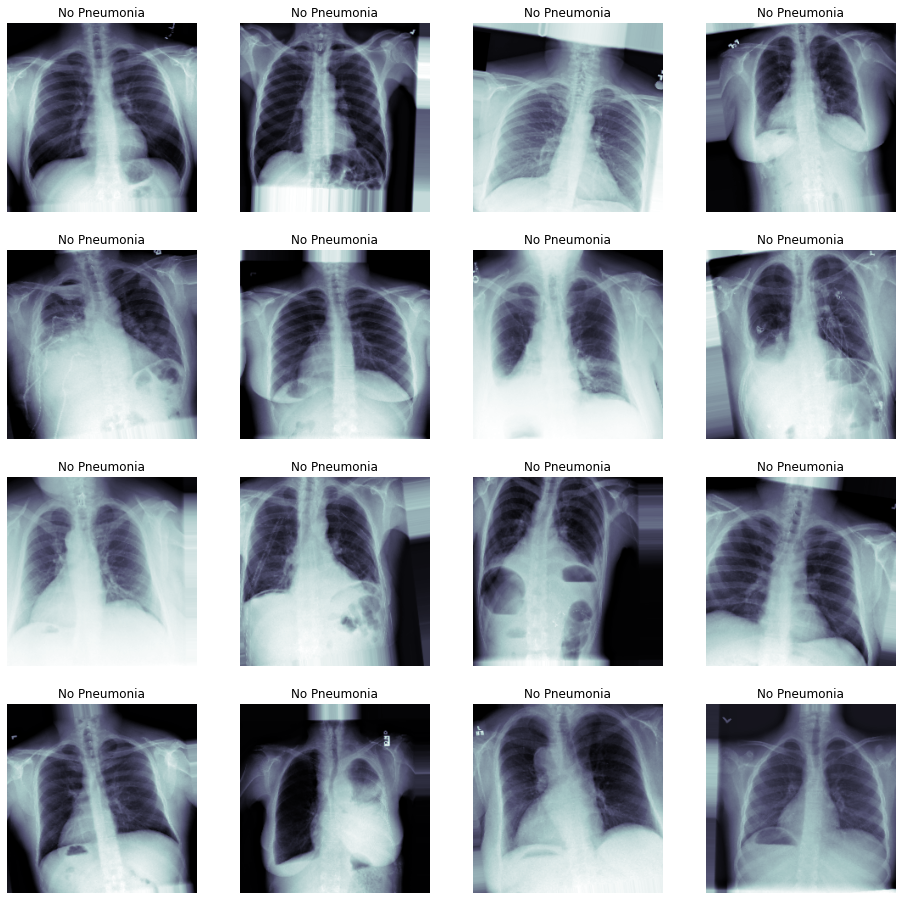

In [17]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(train_generator)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Building model: 

In [18]:
METRICS = [
          keras.metrics.TruePositives(name='tp'),
          keras.metrics.FalsePositives(name='fp'),
          keras.metrics.TrueNegatives(name='tn'),
          keras.metrics.FalseNegatives(name='fn'), 
          keras.metrics.BinaryAccuracy(name='accuracy'),
          keras.metrics.Precision(name='precision'),
          keras.metrics.Recall(name='recall'),
          keras.metrics.AUC(name='auc'),
        ]

In [19]:
# defining model generator
def get_model(metrics = METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    
    densenet = tf.keras.applications.DenseNet201(weights = 'imagenet', include_top=False, pooling = 'avg', input_shape=[224, 224, 3])
    densenet.trainable = True # Using pretrained weights due to compute limitation on the worspace.
    model = tf.keras.Sequential([
            densenet,
            tf.keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias)
            ])

    model.compile(
            optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False),
            loss = keras.losses.BinaryCrossentropy(),
            metrics = METRICS
            )
    return model

In [20]:
# defining learning rate sheduler (currently not used)
LR_START = 0.0001
LR_MAX = 0.0001
LR_MIN = 0.00001
LR_RAMPUP_EPOCHS = 3
LR_SUSTAIN_EPOCHS = 0
LR_EXP_DECAY = .8

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = np.random.random_sample() * LR_START # Using random learning rate for initial epochs.
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX 
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN # Rapid decay of learning rate to improve convergence.
    return lr
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

In [21]:
# defining early stopping
es_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=5,
    mode='max',
    restore_best_weights=True)

In [22]:
checkpoint_path = "training/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

### Start training! 

In [23]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU'))) #check gpu status

Num GPUs Available:  1


In [24]:
# calculating class weights to adress class imbalance
positive_findings = 630
negative_findings = 66680
total = positive_findings+negative_findings

initial_bias = np.log([positive_findings/negative_findings])

weight_for_0 = (1 / negative_findings)*(total)/2.0 
weight_for_1 = (1 / positive_findings)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.50
Weight for class 1: 53.42


In [25]:
model = get_model(output_bias = initial_bias)

74842112/74836368 [==============================] - 4s 0us/step


In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Model)          (None, 1920)              18321984  
_________________________________________________________________
dense (Dense)                (None, 1)                 1921      
Total params: 18,323,905
Trainable params: 18,094,849
Non-trainable params: 229,056
_________________________________________________________________


In [27]:
#with active_session():
history = model.fit(train_generator, 
                        epochs = 10, 
                        verbose = 2, 
                        validation_data = validation_generator, 
                        callbacks = [lr_callback, es_callback, cp_callback], 
                        class_weight = class_weight)


Epoch 00001: LearningRateScheduler reducing learning rate to 7.894579079128151e-05.
Epoch 1/10

Epoch 00001: saving model to training/cp.ckpt
1683/1683 - 2210s - loss: 0.8471 - tp: 254.0000 - fp: 19617.0000 - tn: 33727.0000 - fn: 250.0000 - accuracy: 0.6311 - precision: 0.0128 - recall: 0.5040 - auc: 0.5766 - val_loss: 0.6466 - val_tp: 75.0000 - val_fp: 4836.0000 - val_tn: 8500.0000 - val_fn: 51.0000 - val_accuracy: 0.6370 - val_precision: 0.0153 - val_recall: 0.5952 - val_auc: 0.6622 - lr: 7.8946e-05

Epoch 00002: LearningRateScheduler reducing learning rate to 9.656227518696936e-05.
Epoch 2/10

Epoch 00002: saving model to training/cp.ckpt
1683/1683 - 2220s - loss: 0.6889 - tp: 286.0000 - fp: 21078.0000 - tn: 32266.0000 - fn: 218.0000 - accuracy: 0.6045 - precision: 0.0134 - recall: 0.5675 - auc: 0.6195 - val_loss: 0.5961 - val_tp: 62.0000 - val_fp: 4489.0000 - val_tn: 8847.0000 - val_fn: 64.0000 - val_accuracy: 0.6618 - val_precision: 0.0136 - val_recall: 0.4921 - val_auc: 0.6045 -

In [28]:
"""Plotting the history of model training 
(due to time requirement of the training 
and workspace timing out this may not be available):"""

def plot_metrics(history):
    metrics =  ['loss', 'auc', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch,  history.history[metric], color='b', label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
             color='r', linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
          plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
          plt.ylim([0.8,1])
        else:
          plt.ylim([0,1])

    plt.legend()

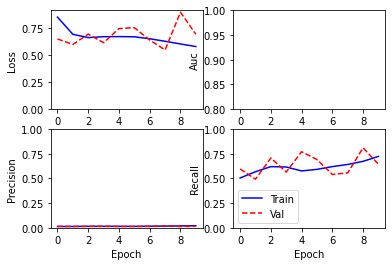

In [29]:
if history is not None:
    plot_metrics(history)

In [30]:
model.save('models/dense_model_retrained')

##### Plotting some performance statistics:

In [31]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
weight_path = checkpoint_path
model.load_weights(weight_path)

In [32]:
results = model.evaluate(validation_generator, verbose=2)
print("Loss: {:0.4f}".format(results[0]))

421/421 - 243s - loss: 0.6899 - tp: 81.0000 - fp: 4905.0000 - tn: 8431.0000 - fn: 45.0000 - accuracy: 0.6323 - precision: 0.0162 - recall: 0.6429 - auc: 0.6826
Loss: 0.6899


In [33]:
# Plotting AUC.
def plot_auc(t_y, p_y):
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    fpr, tpr, thresholds = roc_curve(t_y, p_y)
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % ('Pneumonia', auc(fpr, tpr)))
    c_ax.legend()
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')

## Checking presicion recall curve based on thresholds.

def plot_precision_recall_curve(t_y, p_y):
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    precision, recall, thresholds = precision_recall_curve(t_y, p_y)
    c_ax.plot(recall, precision, label = '%s (AP Score:%0.2f)'  % ('Pneumonia', average_precision_score(t_y,p_y)))
    c_ax.legend()
    c_ax.set_xlabel('Recall')
    c_ax.set_ylabel('Precision')

In [34]:
valX, valY = next(validation_generator)
pred_Y = model.predict(valX, batch_size = 32, verbose = True)

1/1 [==============================] - 0s 1ms/step


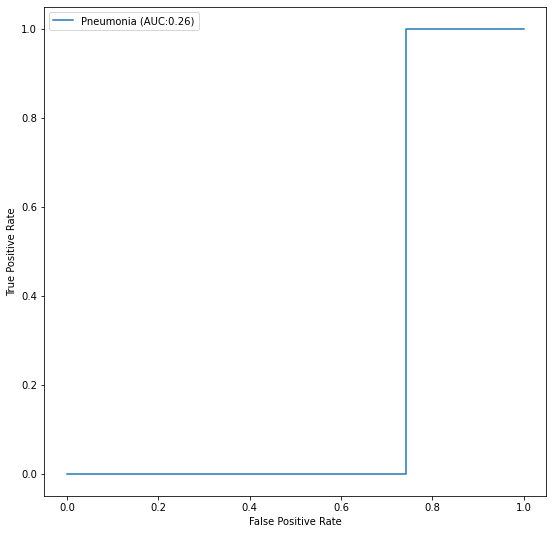

In [35]:
plot_auc(valY, pred_Y)

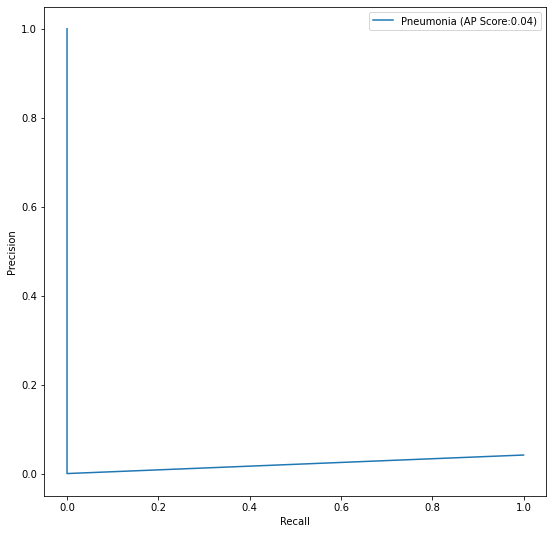

In [36]:
plot_precision_recall_curve(valY, pred_Y)

Playing with classification thresholds:

In [37]:
# F1 calulator helper fuction.
def  calc_f1(prec,recall):
    return 2*(prec*recall)/(prec+recall)

In [38]:
precision, recall, thresholds = precision_recall_curve(valY, pred_Y)

In [39]:
# Look at the threshold where precision is 0.8
precision_value = 0.8
idx = (np.abs(precision - precision_value)).argmin() 
print('Precision is: '+ str(precision[idx]))
print('Recall is: '+ str(recall[idx]))
print('Threshold is: '+ str(thresholds[idx]))
print('F1 Score is: ' + str(calc_f1(precision[idx],recall[idx])))

Precision is: 1.0
Recall is: 0.0


IndexError: index 24 is out of bounds for axis 0 with size 24

In [40]:
# Look at the threshold where recall is 0.8
recall_value = 0.8
idx = (np.abs(recall - recall_value)).argmin() 
print('Precision is: '+ str(precision[idx]))
print('Recall is: '+ str(recall[idx]))
print('Threshold is: '+ str(thresholds[idx]))
print('F1 Score is: ' + str(calc_f1(precision[idx],recall[idx])))

Precision is: 0.041666666666666664
Recall is: 1.0
Threshold is: 0.3955319
F1 Score is: 0.07999999999999999


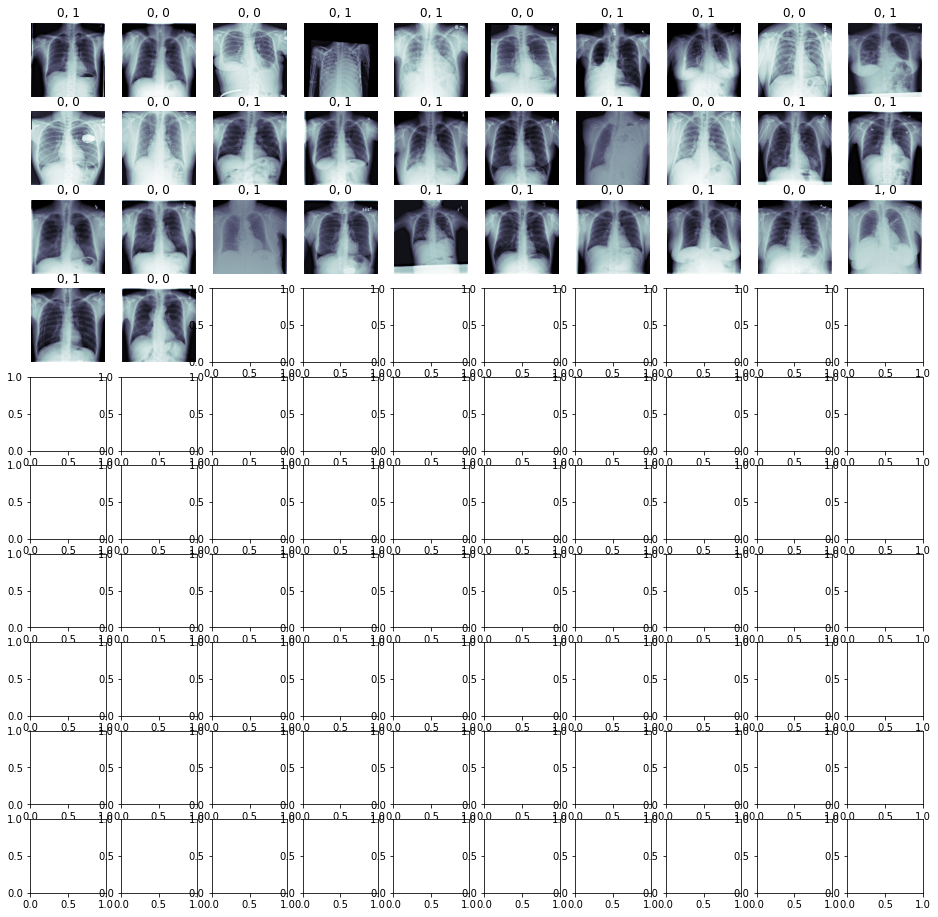

In [41]:
## Let's look at some examples of true vs. predicted with our best model: 

YOUR_THRESHOLD = 0.5

fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:100], valY[0:100], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > YOUR_THRESHOLD:
             c_ax.set_title('1, 1')
        else:
             c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > YOUR_THRESHOLD: 
             c_ax.set_title('0, 1')
        else:
             c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

In [42]:
## Just save model architecture to a .json:

model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)